## Chapter 3 [Imaging](Ch3-Imaging.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />

# SEM Image Processing


part of 

## [Analysis of Scanning Electron Microscope Data](_Analysis_of_Scanning_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes
part of 



## First we import all relvant libraries

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook

# Multidimensional Image library
import scipy.ndimage as ndimage

# it is a good idea to show the version numbers at this point for archiving reasons.

notebook_version = '2019.9.01'
print('notebook version: ',notebook_version)

%gui qt

Populating the interactive namespace from numpy and matplotlib
notebook version:  2019.9.01


### Load a SEM image:
As an example we will use an image in the **SEM_images** directory

<IPython.core.display.Javascript object>


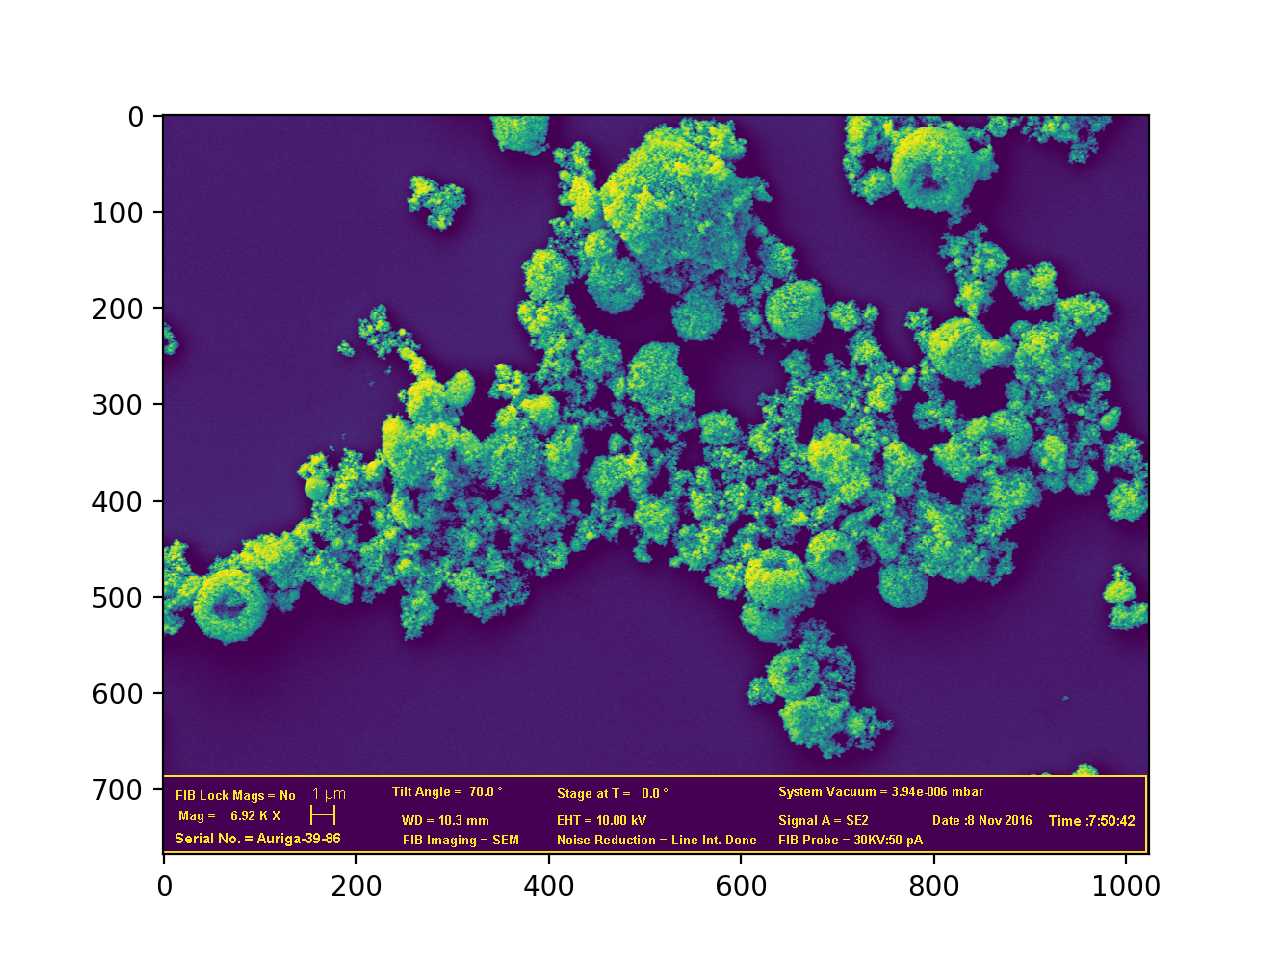

In [2]:
from PyQt5 import QtGui, QtWidgets

path = ''

if len(path)<2:
    path = '.'

fname, file_filter = QtWidgets.QFileDialog.getOpenFileName(None, "Select a file...", path)
        

from PIL import Image
im = Image.open(fname)
data = numpy.array(im)
plt.figure()
plt.imshow(data)#, cmap = 'gray')


## An Electronic Image

is  a matrix. ![pixel.jpg](images/pixel.jpg)


In an SEM the origin is usually on the top left, and the fast scan direction is to the right (x-axis).

The contrast of an image is given by the standard deviation. The higher this standard deviation the more contrast is in the image.

Her we determine the minimum maximum and the contrast of the image we opened.

In [3]:
print(f' minimum intensity is {data.min():.2f} counts and maximum intensity is {data.max():.2f}')
print(f'The image contrast is {np.std(data):.2f}')


 minimum intensity is 0.00 counts and maximum intensity is 255.00
The image contrast is 69.58


## Histogram

Another way to look at the information content and contrast is the histogram of intensities

<IPython.core.display.Javascript object>


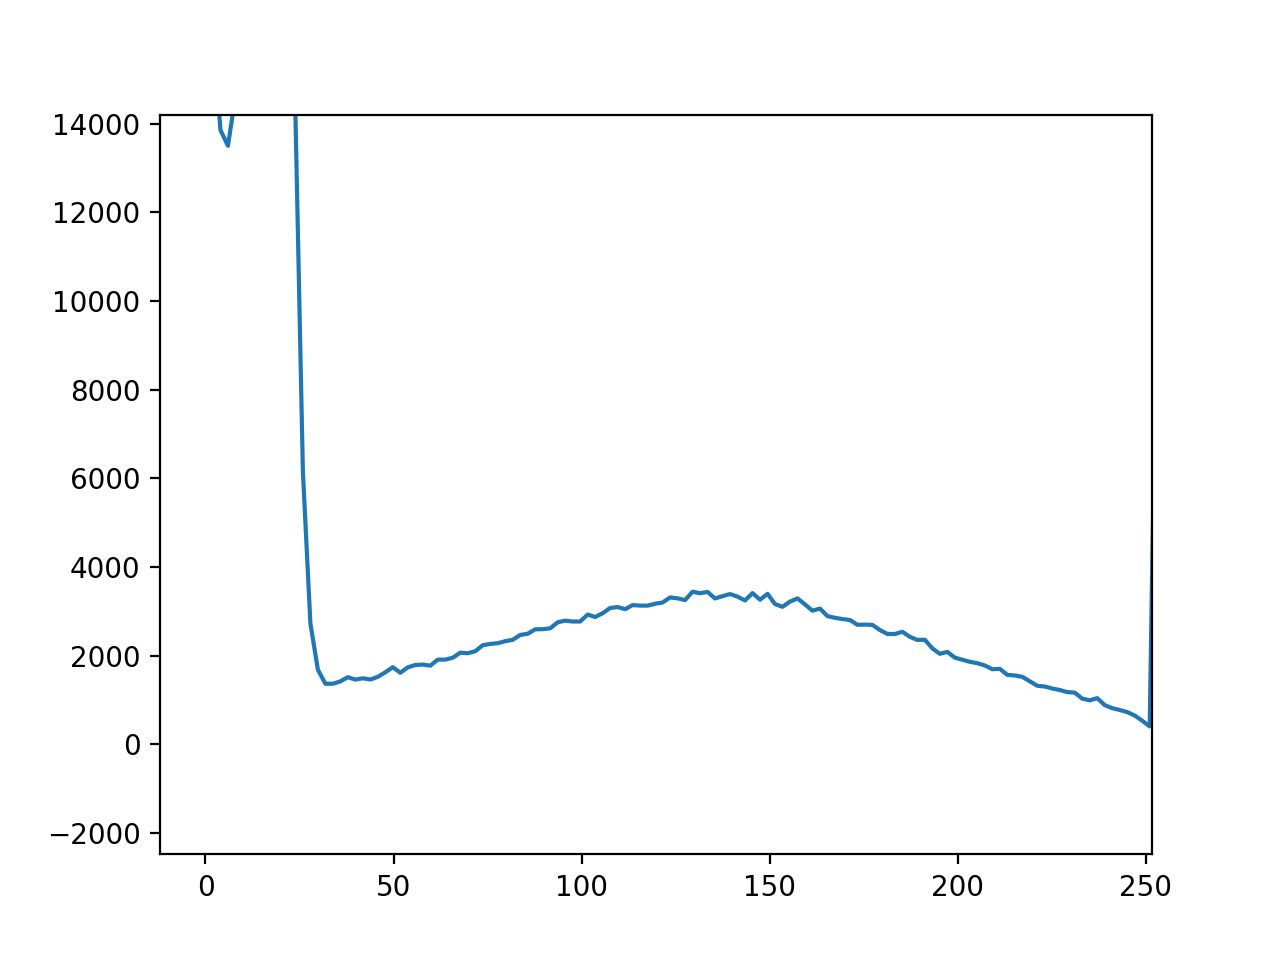

In [11]:
nbins = int(256/2)
hist_frequency, histo_intensities = np.histogram(data, bins=nbins)

plt.figure()
plt.plot(histo_intensities[:-1],hist_frequency,label='intensities');


## Image Scale

In the age of electronic image acquisition, magnification is no longer a good measure (if it ever was).

There are two ways to express the scale of an image:
* field of view (FOV)
* length per pixel (in an SEM that would be nanometers per pixel).

There is a scale bar at the bottom of the image and we need to determine the **nanometers_per_pixel** of this image.
The assumption is that the pixel are square and so the FOV in x and y is then given by the image size and the pixel size.



<IPython.core.display.Javascript object>


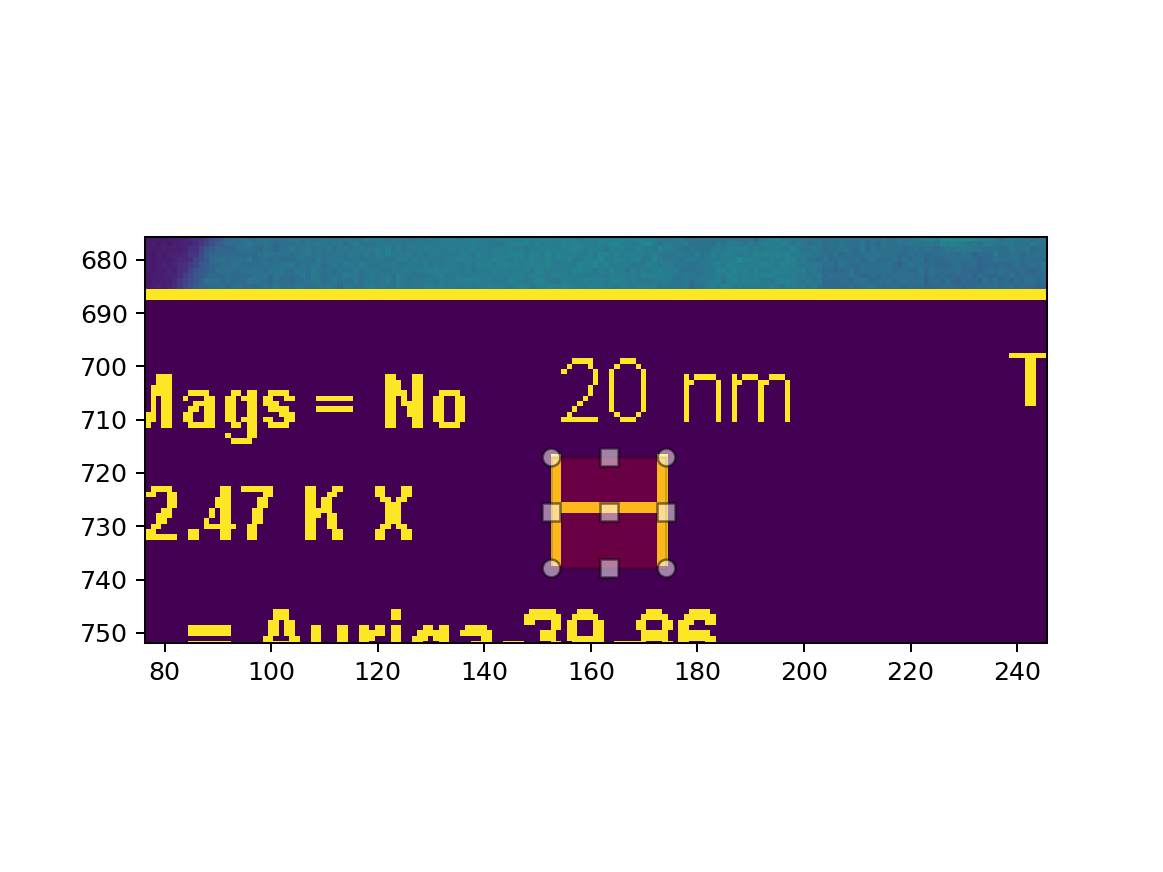

In [33]:
plt.figure()

plt.imshow(data)
import matplotlib.widgets as mwidgets
def onselect(vmin, vmax):
    print(vmin, vmax)
rectprops = dict(facecolor='blue', alpha=0.5)
span = mwidgets.RectangleSelector(plt.gca(), None,
                       drawtype='box', useblit=False, button=[1], 
                       minspanx=5, minspany=5, spancoords='pixels', 
                       interactive=True)
             

In [35]:
rectangle_width= span.extents[1]-span.extents[0]
scale_bar_width = 20.0
print(f'The width of scale bar is {rectangle_width:.1f} pixels which is {scale_bar_width:.0f} nm')
nm_per_pixel = scale_bar_width/rectangle_width
print(f'That is {nm_per_pixel:.2f} nm/pixel')

The width is 21.5 pixels which is 20 nm
That is 0.93 nm/pixel


## Line Profile

(768, 1024)


<IPython.core.display.Javascript object>


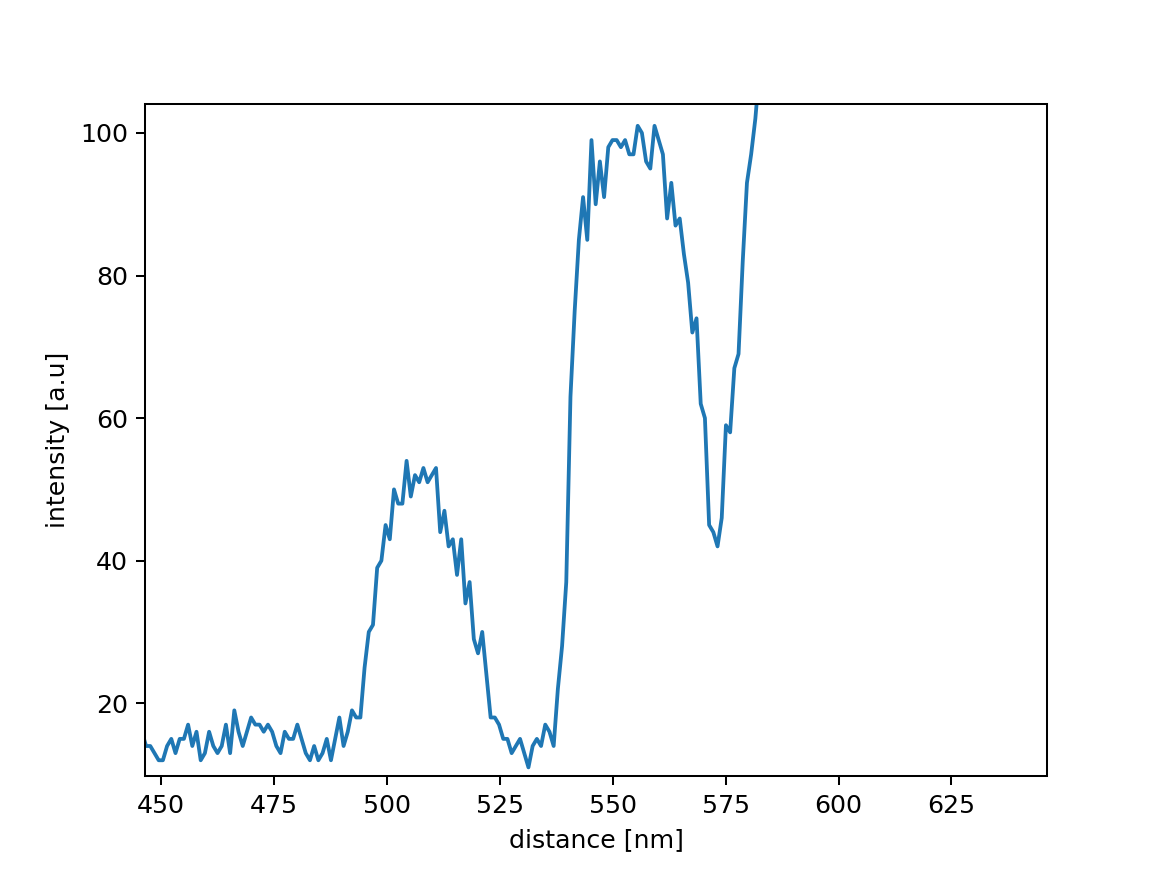

<IPython.core.display.Javascript object>


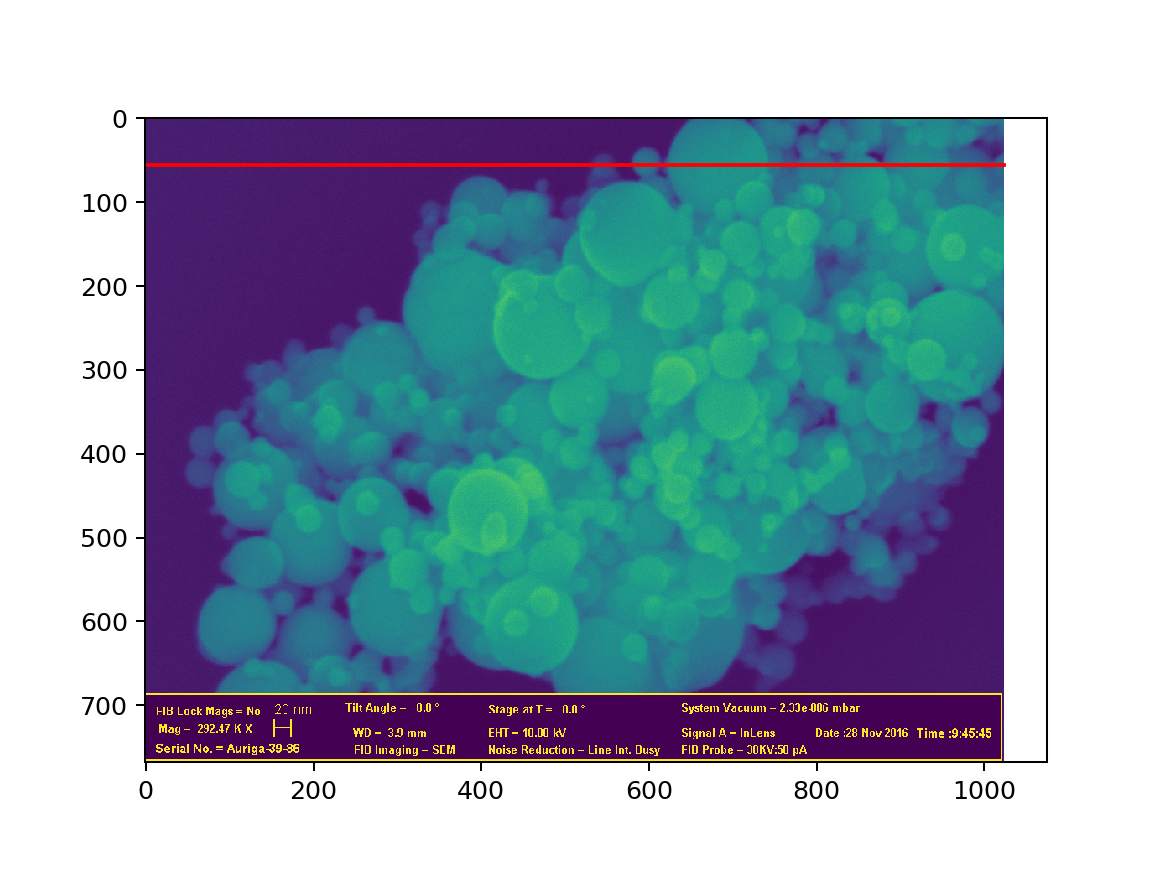

In [48]:
line_number = 55
width = 2

print(data.shape)
x = np.linspace(0,data.shape[1]-1,data.shape[1])*nm_per_pixel
plt.figure()
plt.plot(x,data[line_number,:])
plt.ylabel('intensity [a.u]')
plt.xlabel('distance [nm]');

plt.figure()
plt.imshow(data)
plt.plot([0,data.shape[1]],[line_number,line_number], color = 'red');

## Image Resolution
The resolution in an image can be estimated by the raise of the intensity at a sharp feature. Here, we assume an atomically sharp edge that is smeared out (convoluted) with the electron beam shape.

In the line profile above, zoom in and see what your estimate of the resolution is.

There are several problems with this approach, here are the two most important ones:
* generation of secondary electrons at edges 
* no sharp edge exists



## Random Line Profile

Please be aware that non vertical or horizontal lines require some interpolation to display an intensity profile.

Still this is an important tool in the analysis of features in your image.

<IPython.core.display.Javascript object>


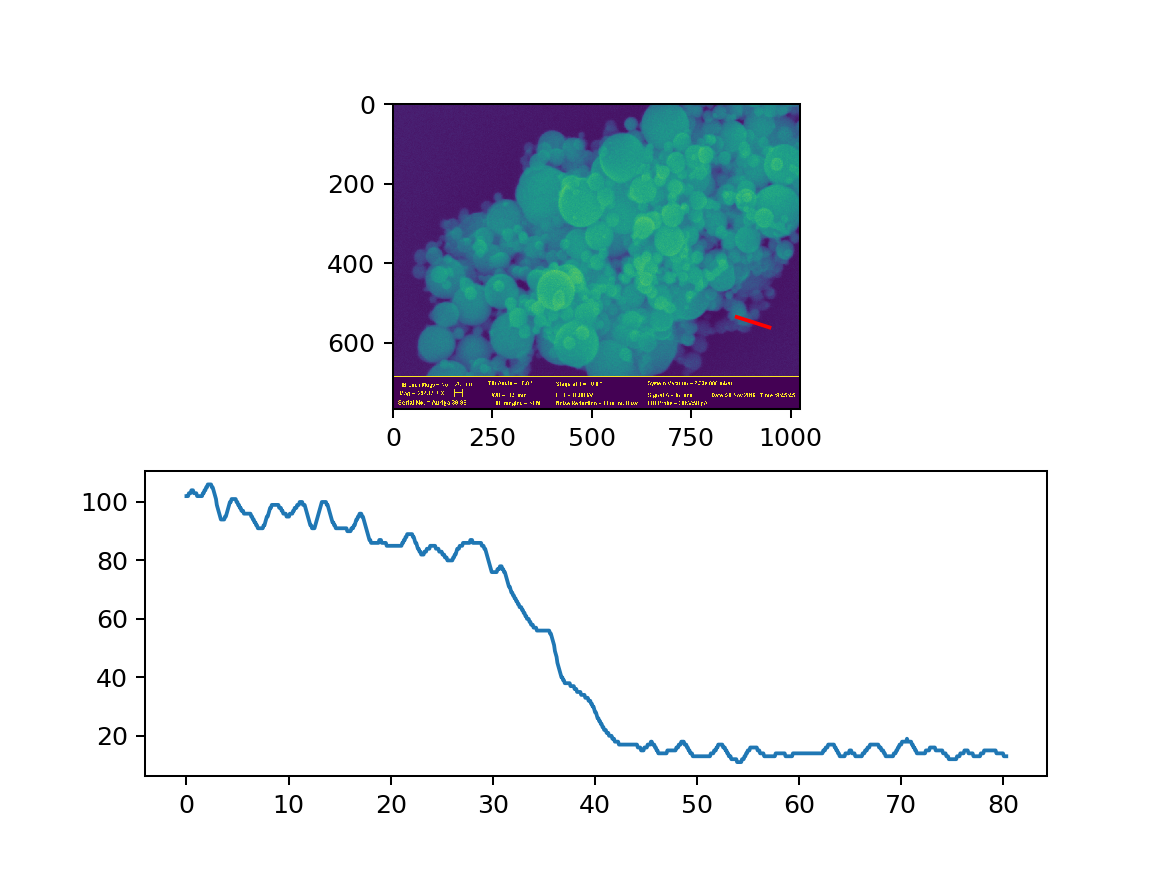

In [50]:
class LineProfile:
    global zi
    def __init__(self, axes,data, nm_per_pixel = 1.):
        self.data = data
        self.axes = axes
        axes[0].imshow(data)
        self.line,  = axes[0].plot([0], [0], color ='red')
        self.xs = list(self.line.get_xdata())
        self.ys = list(self.line.get_ydata())
        self.cid = self.line.figure.canvas.mpl_connect('button_press_event', self.click)
        axes[1].plot([0,1],[0,1])
             
    def click(self, event):
        print('click', event)
        if event.inaxes!=self.line.axes: return
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.xs = self.xs[-2:]
        self.ys = self.ys[-2:]
        
        self.line.set_data(self.xs, self.ys)
        self.line.figure.canvas.draw()
        
        num = 1000
        x, y = np.linspace(self.xs[0], self.xs[1], num), np.linspace(self.ys[0], self.ys[1], num)
        
        # Extract the values along the line, using cubic interpolation
        zi = scipy.ndimage.map_coordinates(self.data.T, np.vstack((x,y)))
        length = np.linalg.norm([linebuilder.xs[0]-linebuilder.xs[1],linebuilder.ys[0]-linebuilder.ys[1]])
        x = np.linspace(0,999,num)/1000*length*nm_per_pixel
        self.zi = zi
        self.axes[1].clear()
        self.axes[1].plot(x,zi)
        self.line.figure.canvas.draw()
        
#-- Plot...
fig, axes = plt.subplots(nrows=2)
linebuilder = LineProfile(axes, data, nm_per_pixel)


## Fourier Transform of Image

<IPython.core.display.Javascript object>


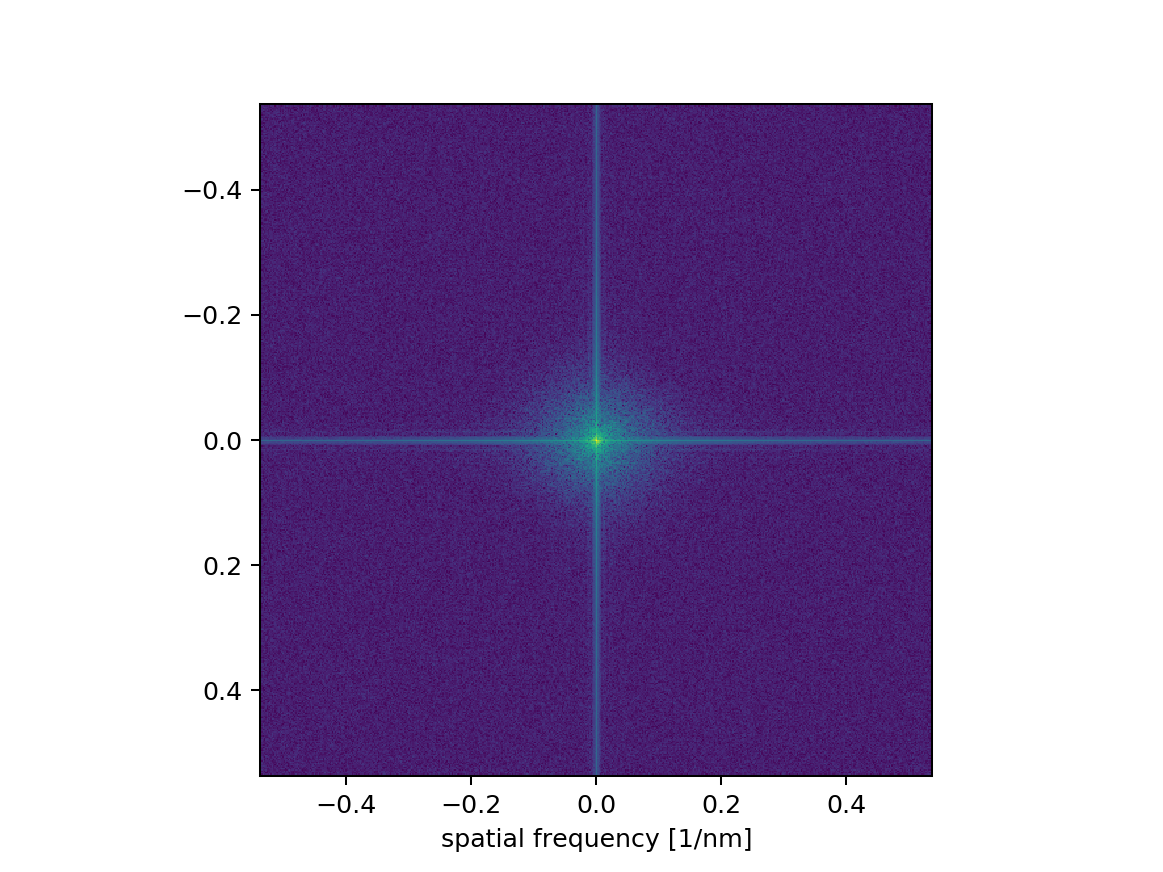

In [72]:
size_x = size_y = 512

image = data[0:size_x,0:size_y]- data[0:size_x,0:size_y].min()
fft_mag = (np.abs((np.fft.fftshift(np.fft.fft2(image)))))

FOV_x = size_x * nm_per_pixel
FOV_y = size_y * nm_per_pixel

## pixel_size in recipical space
rec_scale_x = 1/FOV_x  
rec_scale_y = 1/FOV_y 

## Field of View (FOV) in recipical space please note: rec_FOV_x = 1/(scaleX*2)
rec_FOV_x = rec_scale_x * size_x /2.
rec_FOV_y = rec_scale_y * size_y /2.

## Field ofView (FOV) in recipical space
rec_extend = (-rec_FOV_x,rec_FOV_x,rec_FOV_y,-rec_FOV_y)

fig = plt.figure()
plt.imshow(np.log(1e3+fft_mag).T, extent=rec_extend, origin = 'upper'); 
plt.xlabel('spatial frequency [1/nm]');



## Image Resolution 2

In [76]:
radius_of_circle_of_information = 0.14
print(f'resolution = {1/radius_of_circle_of_information:.2f} nm' )

resolution = 7.14 nm


## More Contrast through Fourier Filtering

Part of the low contrast is the high frequency noise in the diffractogram.
Smoothing with a Gaussian (3pixels wide) increases the contrast on logarithmic intensity scale.

Additionally, the minimum and maximum intensity can be used to increase the plotted contrast. For that we want to exclude 
- the center spot, which does not carry any spatial information and 
- the high frequencies which have always low intensities. 


## Fourier Filtering

We mask the Fourier transformed image so that only the selected information can pass through.

The information is in the center of the Fourier transformed image, the rest is noise.

Please modify the radius of the mask of  the **low-pass** area in the code below and notice the effects on the Fourier filtered image.



<IPython.core.display.Javascript object>


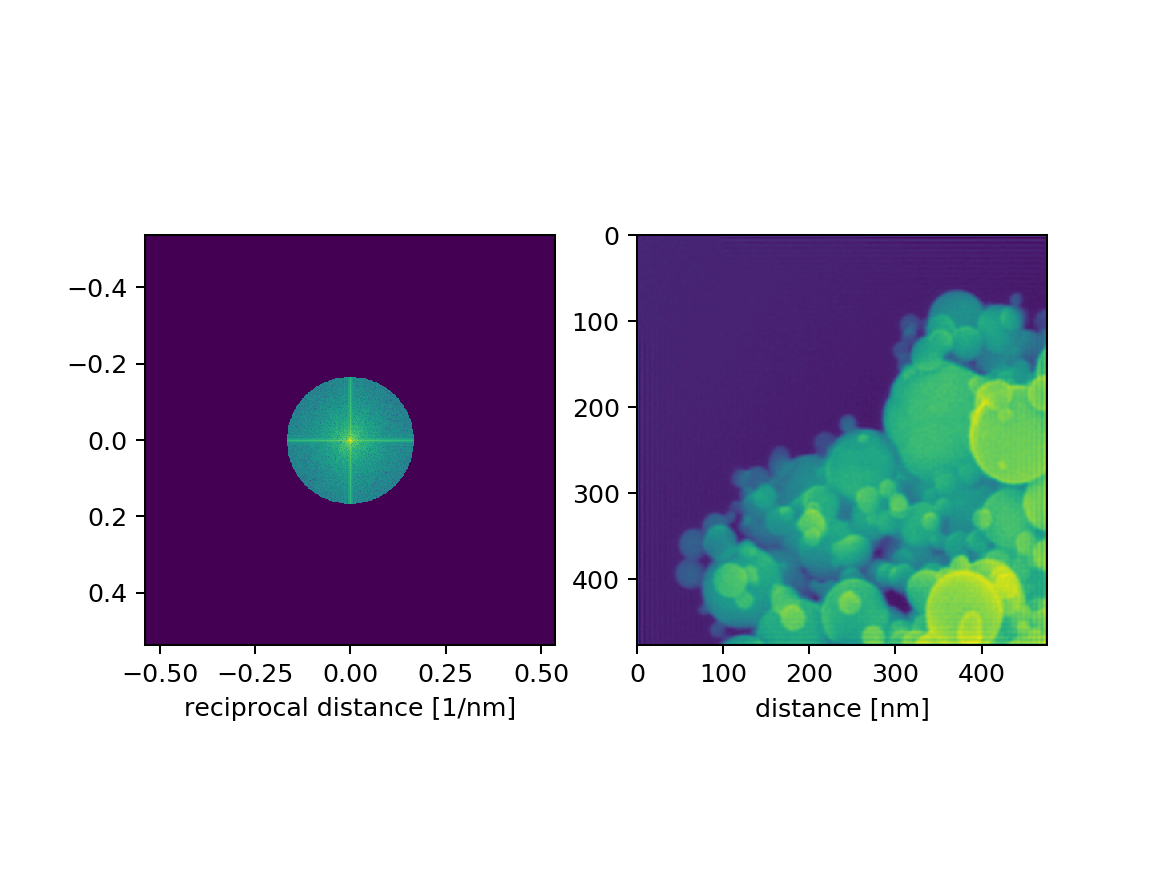

In [85]:
# Input 
low_pass = 1/6 # in 1/nm diameter of mask for low pass filter


#prepare mask
pixels = (np.linspace(0,image.shape[0]-1,image.shape[0])-image.shape[0]/2)* rec_scale_x

x,y = np.meshgrid(pixels,pixels);
mask = np.zeros(image.shape)

# mask reflections

mask = x**2+y**2 < low_pass**2 

plt.figure()
ax1 = plt.subplot(1,2,1)
#ax1.imshow(mask)
fft_filtered = np.fft.fftshift(np.fft.fft2(image))*mask.T
ax1.imshow(np.log(1+np.abs(fft_filtered)).real,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
ax2 = plt.subplot(1,2,2)
filtered = np.fft.ifft2(np.fft.fftshift(fft_filtered))

real_extent = (0,FOV_x,FOV_y,0)
    
ax2.imshow(filtered.real,extent=real_extent, origin = 'upper')
plt.xlabel('distance [nm]');


## Check on filtered images

We don't want to filter anything out that caries information, or at least we want to be aware of that. 
An easy check is to subtract the filtered imag fromt he image and to determine that only noise is left.

Please note that any processing can be easily determined in the Fourier transformed, so be meticulous on reporting what you did to an image.


<IPython.core.display.Javascript object>


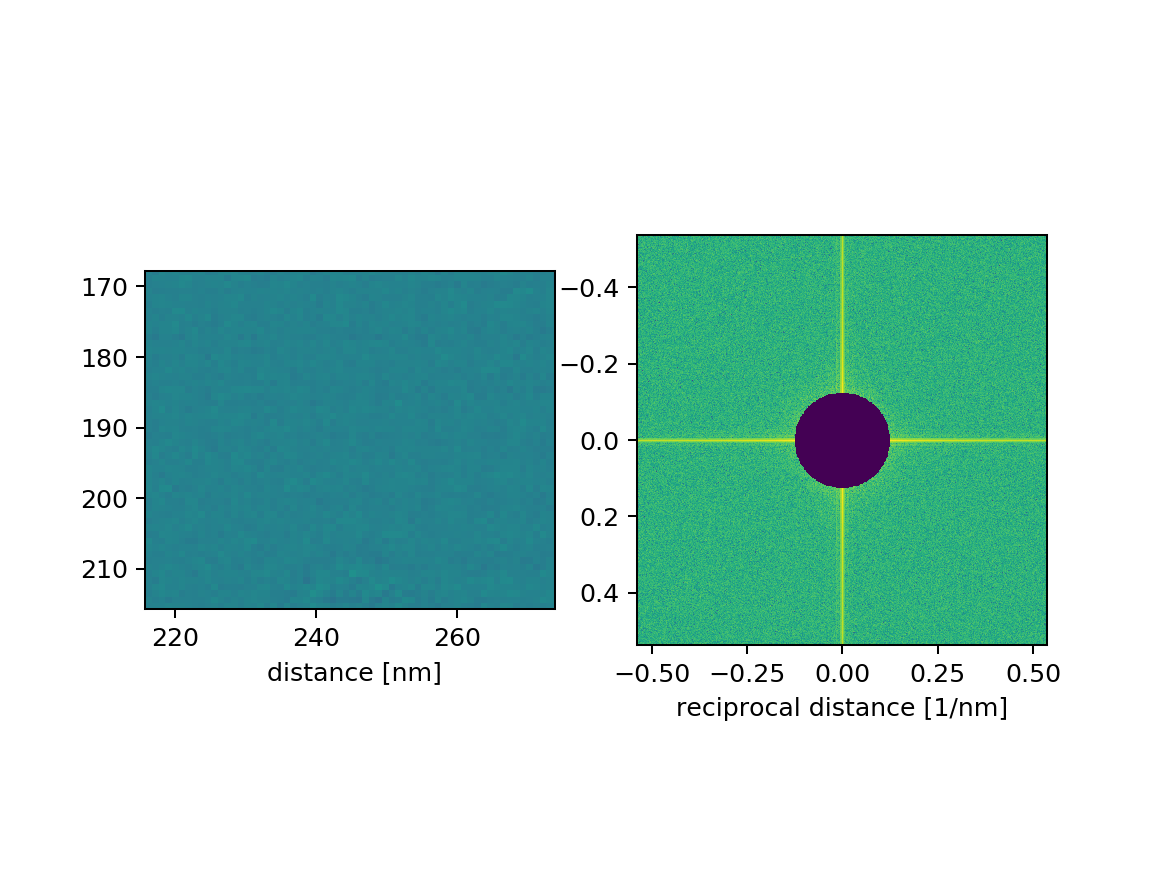

In [81]:
plt.figure()
ax1 = plt.subplot(1,2,1)
ax1.imshow(image-filtered.real,extent=real_extent, origin = 'upper')
plt.xlabel(' distance [nm]')

ax2 = plt.subplot(1,2,2)
fft_difference = np.fft.fftshift(np.fft.fft2(image-filtered.real))
ax2.imshow(np.log(1+np.abs(fft_difference)).real,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]');

## Filtering and Features in Images

There is a whole zoo of images processing techniques that can now be used without any further efforts.

Please look at this [web page](https://scikit-image.org/docs/stable/auto_examples/edges/plot_contours.html#sphx-glr-auto-examples-edges-plot-contours-py)  at [scikit-images](https://scikit-image.org/) from which I copied the code below.

<IPython.core.display.Javascript object>


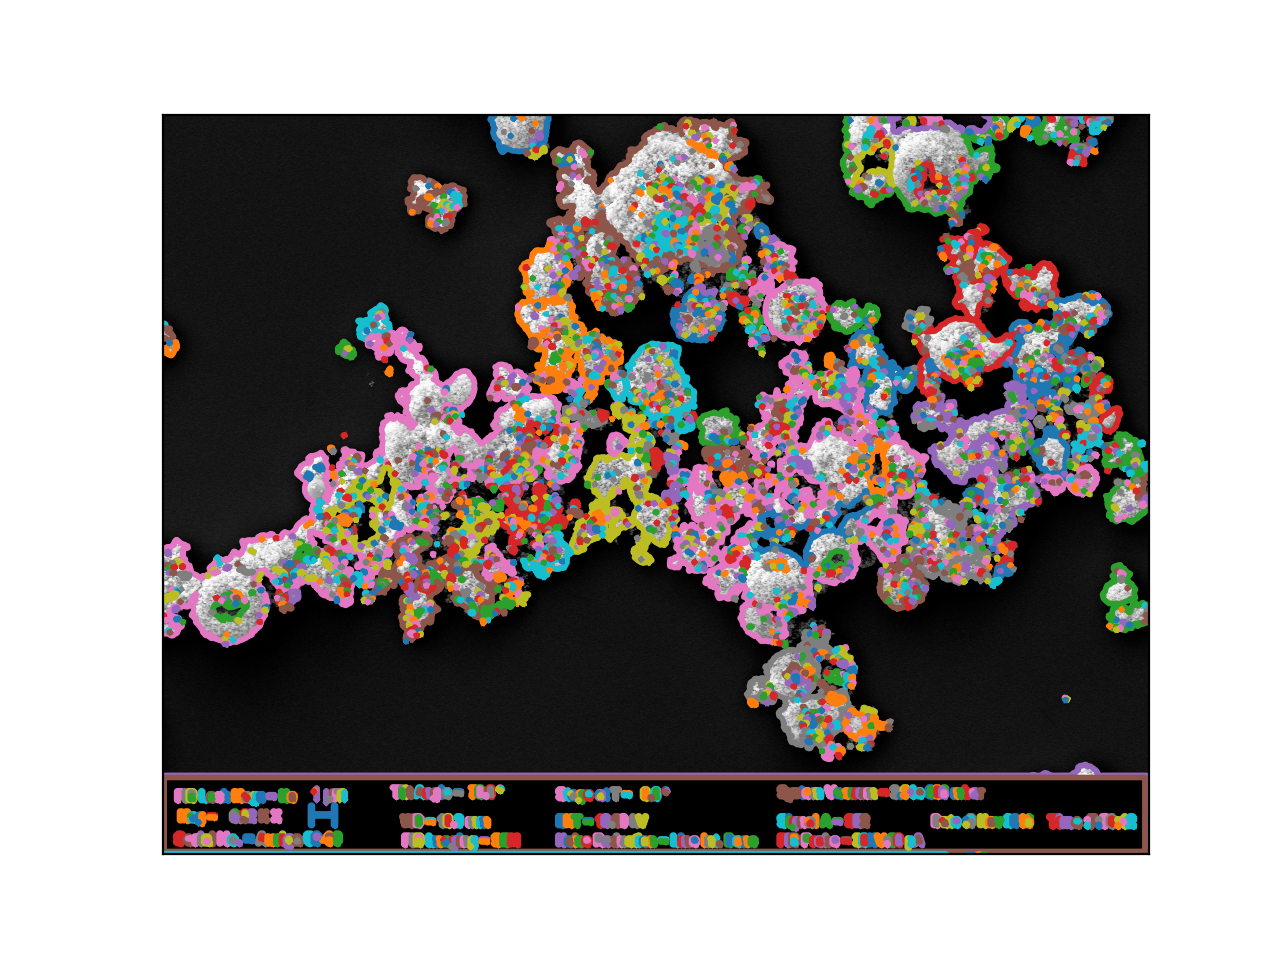

In [14]:
from skimage import measure

# Find contours at a constant value of 0.8
contours = measure.find_contours(data, 100)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(data, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Gaussian Smearing

I copied the following coe from this [web page](https://scipy-lectures.org/advanced/image_processing/) from [scipy](https://www.scipy.org/scipylib/index.html)

<IPython.core.display.Javascript object>


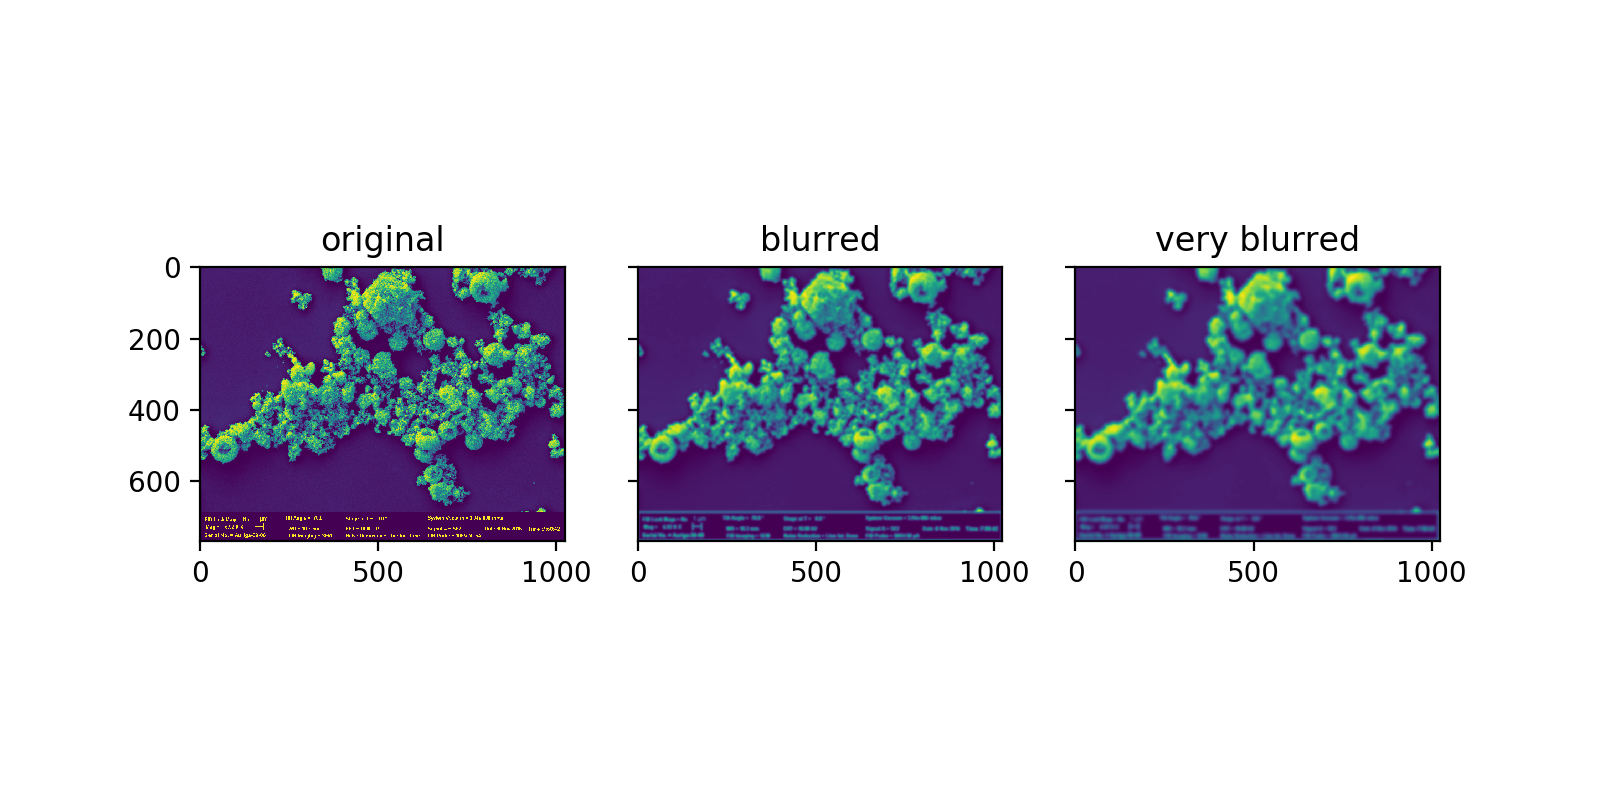

In [25]:
from scipy import misc

blurred_data = ndimage.gaussian_filter(data, sigma=3)

very_blurred_data = ndimage.gaussian_filter(data, sigma=5)


fig, ax = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(data)
ax[0].set_title('original')

ax[1].imshow(blurred_data)
ax[1].set_title('blurred')

ax[2].imshow(very_blurred_data)
ax[2].set_title('very blurred');

## Conclusion:

Fourier Transform is used to evaluate image quality and Fourier Filtering is used to eliminate high frequency noise.


## Back: [Diffraction](Diffraction.ipynb)
## Next: [Contrast Transfer Function](CTF.ipynb)
## Chapter 3: [Imaging](Imaging.ipynb)
## List of Content: [Front](_Analysis_of_Scanning_Electron_Microscope_Data.ipynb)